In [1]:
import pandas as pd
import tensorflow as tf
import regex as re
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

In [2]:
from IPython.display import clear_output

In [3]:
def preprocess_dataframe(df):

  df.fillna(value=0, inplace=True) #Reemplazamos NAN por 0, ya que NAN rompe a Tensorflow

  #Renombramos las columnas que tienen caracteres que TensorFlow no acepta como validos.
  #Estos particularmente son whitespace, coma y parentesis por ejemplo.
  df.rename(columns={'ASP_(converted)':'ASP_converted','Pricing, Delivery_Terms_Quote_Appr':
                    'Pricing_Delivery_Terms_Quote_Appr','Pricing, Delivery_Terms_Approved':
                    'Pricing_Delivery_Terms_Approved','Source ':'Source'},inplace=True)

  df = df[df['Stage'].isin(['Closed Won', 'Closed Lost'])]
  df.loc[:, 'Stage'].replace({'Closed Won':1, 'Closed Lost':0}, inplace=True) #0 corresponde a que el caso fue Closed Lost, 1 a que fue Closed Won.

  df.loc[:, 'Planned_Delivery_Start_Date'] = pd.to_datetime(df['Planned_Delivery_Start_Date'], 'coerce',
                                                                  format='%m/%d/%Y')
  df.loc[:, 'Planned_Delivery_End_Date'] = pd.to_datetime(df['Planned_Delivery_End_Date'], 'coerce',
                                                                                      format='%m/%d/%Y')
  df = df[df['Opportunity_ID'] != 9773] #Hardcodeo este filtrado porque el id 9773 tiene mal cargada la fecha de delivery end, dando una diferencia de 200 anios xd"

  #Creamos una nueva columna (Feature Engineering) que contiene la longitud en dias 
  #estimada de la operacion. En el informe habiamos encontrado que aparentaba haber
  #una relacion cuadratica de decrecimiento a medida que aumentaban los dias donde disminuia
  #la chance de completar la operacion.
  df['Delta_Time'] = df['Planned_Delivery_End_Date'] - df['Planned_Delivery_Start_Date']
  df.loc[:, 'Delta_Time'] = df['Delta_Time'].dt.days
  df['Delta_Time'] = df['Delta_Time'].replace({np.nan:10.0}) #Reemplazo con 10 porque los que no tienen fecha final ganan el 60%, y el analisis de los datos da que el 60% es maso a los 10 dias. Asi no jodo el resto de los datos
  df['Delta_Time'] = df.groupby('Opportunity_ID')['Delta_Time'].transform('max')

  #Pasamos todo a dolares
  currency_conversion = {'AUD':0.707612, 'EUR':1.131064, 'GBP':1.318055, 'JPY':0.008987, 'USD':1.0}
  df['Total_Taxable_Amount_Currency'] = df[['Total_Taxable_Amount_Currency']].replace(currency_conversion)
  df['Total_Taxable_Amount'] = df['Total_Taxable_Amount_Currency'] * df['Total_Taxable_Amount']

  #Modifico la columna Brand para que en vez de decir que marca es, solo diga
  #si tiene o no marca. Es importante aclarar que verificamos que siempre que una oportunidad
  #tiene un producto con marca entonces todos sus productos tienen marca. Esto se cumple
  #tanto en el set de entrenamiento como en el de test, por lo tanto al hacer drop_duplicates
  #no nos va a pasar nunca el caso donde nos pudieramos quedar con una entrada de producto
  #sin marca mientras que algun otro producto si tuviera, ya que confirmamos que o todos tienen
  #marca o ninguno tiene.
  df.loc[df['Brand'] == 'None', 'Brand'] = 'No'
  df.loc[df['Brand'] != 'No', 'Brand'] = 'Yes'

  #Agrego una columna que indique la cantidad de productos que tiene esa
  #oportunidad
  df['Product'] = 1
  df['Product_Amount'] = df.groupby('Opportunity_ID')['Product'].transform(lambda x: x.sum())

  #Agrego una columna que indica si el owner de la cuenta es el mismo que el de la oportunidad
  #o no
  df['Same_Owner'] = (df['Account_Owner'] == df['Opportunity_Owner'])
  df['Same_Owner'] = df['Same_Owner'].replace({False:'No', True:'Yes'})

  #Agrego una columna que indica si tiene o no fecha de expiracion
  df['Quote_Expiry_Date'] = (df['Quote_Expiry_Date'] != 'NaT')
  df.rename(columns={'Quote_Expiry_Date':'Has_Expiry_Date'}, inplace=True)
  df['Has_Expiry_Date'] = df['Has_Expiry_Date'].replace({True:'Yes',False:'No'})

  #Reemplazo las 4 columnas de aprobacion por solo 2 columnas que indiquen si tuvo la aprobacion
  #de delivery y burocratica o no. Recalco que si nunca la necesito seria equivalente a si
  #la necesito y la consiguio.
  df['Delivery_Approved'] = df['Pricing_Delivery_Terms_Quote_Appr'] + df['Pricing_Delivery_Terms_Approved']
  df['Delivery_Approved'] = df['Delivery_Approved'].replace({0:1, 1:0, 2:1})
  df['Bureaucratic_Code_Approved'] = df['Bureaucratic_Code_0_Approval'] + df['Bureaucratic_Code_0_Approved']
  df['Bureaucratic_Code_Approved'] = df['Bureaucratic_Code_Approved'].replace({0:1, 1:0, 2:1})
  df['Approved'] = df['Delivery_Approved'] & df['Bureaucratic_Code_Approved']

  #Cambio TRF por una columna que es el valor medio de los TRF de la oportunidad
  df["TRF"] = df.groupby("Opportunity_ID")["TRF"].transform("mean")

  def combineProducts(x):
    products = ""
    added = []
    for product in x:
      product = re.findall('\d+', product)[0]
      if added.count(product) == 0:
        products += (product)
        added.append(product)
    return products

  #Junto todos los productos en una sola entrada
  df['Products'] = df.groupby('Opportunity_ID')['Product_Family'].transform(combineProducts)

  #Pruebo dropear duplicados, solo cambia el producto. Si el producto no importa
  #entonces dropear duplicados no deberia importar. Obviamente dropeo el producto en el que
  #quede tambien.
  df.drop_duplicates('Opportunity_Name',inplace=True)
  df.drop(columns=['Product_Name','Product_Family','Opportunity_Name'],inplace=True)

  #Normalizo las columnas numericas
  normalized_columns = ['ASP_converted','TRF','Total_Taxable_Amount', 'Product_Amount', 'Delta_Time']
  for column in normalized_columns:
    df[column] = (df[column] - df[column].mean()) / df[column].std()

  #Borro columnas que tengan el mismo dato en todas las entradas, o inconsecuentes como el ID / Opportunity_ID
  df.drop(columns=['Submitted_for_Approval', 'Last_Activity', 'ASP_(converted)_Currency', 
                  'Prod_Category_A', 'ID', 'Opportunity_ID', 
                   'Actual_Delivery_Date'],inplace=True)

  #Dropeamos las columnas que no utilizamos
  df.drop(columns=['Account_Created_Date','Opportunity_Created_Date',
                   'Last_Modified_Date','Planned_Delivery_Start_Date',
                   'Planned_Delivery_End_Date',
                   'Month', 'Delivery_Year','Price','ASP','ASP_Currency',
                   'Total_Amount_Currency',
                   'Total_Amount','Total_Taxable_Amount_Currency','Currency',
                   'Product_Category_B','Last_Modified_By', 'Account_Owner',
                   'Opportunity_Owner','Account_Name','Product_Type','Size',
                   'Billing_Country', 'Pricing_Delivery_Terms_Quote_Appr',
                   'Pricing_Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval',
                   'Bureaucratic_Code_0_Approved',
                   'Approved','Territory', "Sales_Contract_No"]
                   ,inplace=True)

  return df

In [4]:
df = pd.read_csv("Train_TP2_Datos_2020-2C.csv") 
df = preprocess_dataframe(df)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [5]:
#Setup para el Label Encoding

le = preprocessing.LabelEncoder()
categorical_columns = ["Region","Bureaucratic_Code","Source","Account_Type",
                       "Opportunity_Type","Quote_Type","Delivery_Terms","Brand",
                       "Has_Expiry_Date","Delivery_Quarter","Same_Owner"]

no_enc_df = df.copy() #Creo este aux para mantener el encoding para las predicciones

In [6]:
#Le aplico la codificacion a las columnas categoricas

for feature in categorical_columns:
  le.fit(df[feature]) #Calcula los codigos de cada valor de la serie que recibe
  df[feature] = le.transform(df[feature]) #Le asigno al df los valores codificados

In [7]:
#Tomo la columna target para el target y luego la dropeo del dataset

target = df["Stage"].copy()
df.drop(columns=["Stage"],inplace=True)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.values, target, test_size=0.05) #Separa el df en sets de "training" y validacion

#Normalizacion de las columnas
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
log_loss_min = 100
curr_log_loss = 0
best_accuracy = 0
curr_accuracy = 0
best_n = 0

plot_points = [] #Para despues hacer el grafico de K vs LogLoss

model = KNeighborsClassifier()
best_model = model #Creo este aux para despues hacer las predicciones, ya que sino model queda con el ultimo i

for n in range(2,100):
  print("n =", n)
  model = KNeighborsClassifier(n_neighbors=n)
  model.fit(X_train,y_train)
  y_pred = model.predict_proba(X_test)
  curr_log_loss = metrics.log_loss(y_test, y_pred)
  plot_points.append(curr_log_loss)
  print(curr_log_loss)
  if (curr_log_loss < log_loss_min):
        log_loss_min = curr_log_loss
        best_n = n
        best_model = model


print(best_n, log_loss_min)

n = 2
4.391915325426601
n = 3
3.189323200470747
n = 4
1.9208512246147942
n = 5
1.457225059047875
n = 6
1.057644767661353
n = 7
0.9912451139293146
n = 8
0.8561105622963601
n = 9
0.7895189937105027
n = 10
0.6612592269002951
n = 11
0.6675515273786352
n = 12
0.5398495511698373
n = 13
0.47428173940551627
n = 14
0.4830507194474774
n = 15
0.48523202141921373
n = 16
0.4241717368938433
n = 17
0.4291565016592444
n = 18
0.4343305369877561
n = 19
0.43788447218868853
n = 20
0.44011636384431085
n = 21
0.4385851017664061
n = 22
0.44073278205343447
n = 23
0.44121006456321527
n = 24
0.4418846514793777
n = 25
0.44723499742556727
n = 26
0.44458118896427007
n = 27
0.44610378626562613
n = 28
0.44743749499577173
n = 29
0.4480702517274216
n = 30
0.44560281152155434
n = 31
0.44631344675022144
n = 32
0.4451759706392296
n = 33
0.4453772823444469
n = 34
0.445255719592184
n = 35
0.446972958525115
n = 36
0.44750591459306965
n = 37
0.44798586307832494
n = 38
0.44840367549502935
n = 39
0.45024204591871503
n = 40
0.4

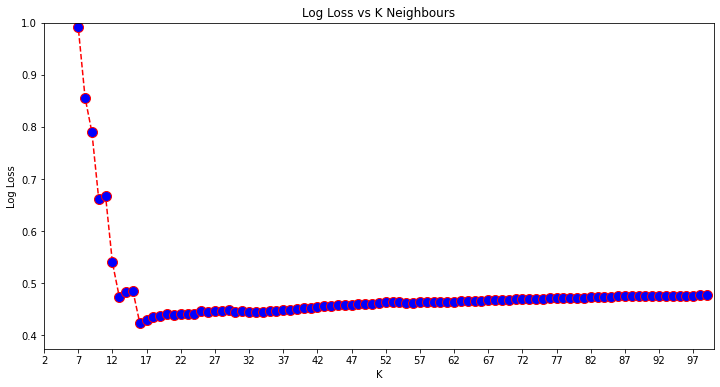

In [10]:
#Grafico de K vs LogLoss

plt.figure(figsize=(12, 6))
plt.xticks(range(2,101,5))
plt.ylim(log_loss_min - 0.05,1)
plt.xlim(2,100)
plt.plot(range(2, 100), plot_points, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
plt.title('Log Loss vs K Neighbours')
plt.xlabel('K')
plt.ylabel('Log Loss')
plt.savefig("k vs logloss")

In [11]:
#Aca empiezo a hacer las predicciones

frio_test_df = pd.read_csv('Test_TP2_Datos_2020-2C.csv')
frio_test_df['Stage'] = 'Closed Won' #Esto esta solo para que haga el preprocess, pero al final se dropea esta columna
pred_df = frio_test_df[['Opportunity_ID']] #Esta columna la dropea el preprocesado sino
pred_df.drop_duplicates(subset='Opportunity_ID', inplace=True)
frio_test_df = preprocess_dataframe(frio_test_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
#Codifico las columnas categoricas

for feature in categorical_columns:
  le.fit(no_enc_df[feature])
  frio_test_df[feature] = le.transform(frio_test_df[feature])

In [13]:
frio_test_df.drop(columns=["Stage"],inplace=True)
features = frio_test_df.values

#Escalo todas las columnas.
scaler.fit(features)
features = scaler.transform(features)

predictions = best_model.predict_proba(features)
pred_df['Target'] = predictions[:,1]
pred_df.to_csv('prediccionesFrioFrio.csv', index=False)

In [14]:
#Pruebo hacer el "train" sin train/test split

df = pd.read_csv("Train_TP2_Datos_2020-2C.csv") 
df = preprocess_dataframe(df)

for feature in categorical_columns:
  le.fit(df[feature])
  df[feature] = le.transform(df[feature])

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [15]:
target = df["Stage"].copy()
df.drop(columns=["Stage"],inplace=True)
features = df.values

scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)

best_model.fit(features,target)#Uso la cantidad de vecinos que dio mejor LogLoss

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=16, p=2,
                     weights='uniform')

In [16]:
test_features = frio_test_df.values

scaler = StandardScaler()
scaler.fit(test_features)
test_features = scaler.transform(test_features)

predictions = best_model.predict_proba(test_features)

pred_df['Target'] = predictions[:,1]

pred_df.to_csv('prediccionesFrioFrioSinTest.csv', index=False)